In [1]:
import os
import sys
import pickle
import numpy as np
import matplotlib.pyplot as plt

# Add the folder containing your custom modules to the path
sys.path.append(r"E:\Dropbox (Weizmann Institute)\Lab\Code\Python Scripts Jupyter")
from entities_v2 import GCaMPData, LimbData, Frame, Clip, Experiment

Parameters & Constants

In [2]:
data_folder = r'Z:\UriMons\Fiber Photometry\adBNST_eEPA_GCaMP8s\Processed_Data\All_pikles'
frame_rate = 30  # Hz
pre_bout_seconds = 4  # seconds before bout to consider
bout_seconds = 2
pre_bout_frames = int(pre_bout_seconds * frame_rate)
bout_frames = int(bout_seconds * frame_rate)

time_bins = {
    "P1": (0, 600),
    "P2": (600, 1200),
    "P3": (1200, 1800),
    "P4": (1800, 2400),
    "P5": (2400, 3000)
}

Load Experiments

In [3]:
loaded_objects = []
for fname in os.listdir(data_folder):
    if fname.endswith('.pkl'):
        path = os.path.join(data_folder, fname)
        with open(path, 'rb') as f:
            exp = pickle.load(f)
            loaded_objects.append(exp)
        print(f"Loaded: {fname}")
print(f"Total .pkl files loaded: {len(loaded_objects)}")

# Generate smoothed grooming bouts for each Experiment
for exp in loaded_objects:
    exp.smooth_grooming_bouts_generator(threshold=60)

Loaded: M329_eEPA_R_adBNST.pkl
Loaded: M338_eEPA_R_adBNST.pkl
Loaded: M344_eEPA_R_adBNST.pkl
Loaded: M352_eEPA_R_adBNST.pkl
Loaded: M354_eEPA_R_adBNST.pkl
Loaded: M365_eEPA_R_adBNST.pkl
Loaded: M406_eEPA_R_adBNST.pkl
Loaded: M407_eEPA_R_adBNST.pkl
Loaded: M416_eEPA_R_adBNST.pkl
Loaded: M420_eEPA_R_adBNST.pkl
Total .pkl files loaded: 10


 Split into Genotype Groups

In [4]:
def get_sapap_genotype(geno_str):
    if "Sapap(" in geno_str:
        return geno_str.split("Sapap(")[1].split(")")[0]
    return None

group_WT, group_KO = [], []
for exp in loaded_objects:
    g = get_sapap_genotype(exp.Genotype)
    if g == 'WT':
        group_WT.append(exp)
    elif g == 'KO':
        group_KO.append(exp)
    else:
        print(f"Warning: Unknown genotype for Mouse {exp.Mouse_id}")
print(f"WT count: {len(group_WT)}, KO count: {len(group_KO)}")

WT count: 4, KO count: 6


Counting Functions

In [5]:
def count_bouts(experiments, smoothed=False):
    kind = 'Smoothed' if smoothed else 'Raw'
    total = 0
    print(f"\nCounting {kind} bouts:")
    for exp in experiments:
        bouts = exp.smooth_grooming_bouts if smoothed else exp.Grooming_annotations
        n = len(bouts) if bouts else 0
        print(f"  Mouse {exp.Mouse_id}: {n}")
        total += n
    print(f"Total {kind} bouts: {total}")
    return total


def count_bouts_by_time_bins(experiments, label, smoothed=False):
    kind = 'Smoothed' if smoothed else 'Raw'
    counts = {bn: 0 for bn in time_bins}
    print(f"\n{kind} bouts per bin for {label}:")
    for exp in experiments:
        bouts = exp.smooth_grooming_bouts if smoothed else exp.Grooming_annotations
        if not bouts:
            continue
        for start, _ in bouts:
            t = start / frame_rate
            for bn, (b0, b1) in time_bins.items():
                if b0 <= t < b1:
                    counts[bn] += 1
                    break
    for bn, c in counts.items():
        print(f"  {bn}: {c}")
    return counts

# Example counts
count_bouts(group_WT, smoothed=False)
count_bouts(group_WT, smoothed=True)
count_bouts_by_time_bins(group_WT, 'WT', smoothed=False)
count_bouts_by_time_bins(group_WT, 'WT', smoothed=True)
count_bouts(group_KO, smoothed=False)
count_bouts(group_KO, smoothed=True)
count_bouts_by_time_bins(group_KO, 'KO', smoothed=False)
count_bouts_by_time_bins(group_KO, 'KO', smoothed=True)


Counting Raw bouts:
  Mouse M329: 62
  Mouse M344: 70
  Mouse M354: 98
  Mouse M365: 52
Total Raw bouts: 282

Counting Smoothed bouts:
  Mouse M329: 51
  Mouse M344: 57
  Mouse M354: 75
  Mouse M365: 45
Total Smoothed bouts: 228

Raw bouts per bin for WT:
  P1: 73
  P2: 2
  P3: 101
  P4: 67
  P5: 38

Smoothed bouts per bin for WT:
  P1: 62
  P2: 2
  P3: 81
  P4: 53
  P5: 29

Counting Raw bouts:
  Mouse M338: 55
  Mouse M352: 76
  Mouse M406: 90
  Mouse M407: 153
  Mouse M416: 59
  Mouse M420: 44
Total Raw bouts: 477

Counting Smoothed bouts:
  Mouse M338: 46
  Mouse M352: 59
  Mouse M406: 70
  Mouse M407: 97
  Mouse M416: 48
  Mouse M420: 31
Total Smoothed bouts: 351

Raw bouts per bin for KO:
  P1: 136
  P2: 30
  P3: 126
  P4: 85
  P5: 99

Smoothed bouts per bin for KO:
  P1: 96
  P2: 23
  P3: 99
  P4: 70
  P5: 63


{'P1': 96, 'P2': 23, 'P3': 99, 'P4': 70, 'P5': 63}

Valid Bouts by Bin

In [6]:
def get_valid_bouts_by_bin(experiments, smoothed=False):
    bins = {bn: {} for bn in time_bins}
    for exp in experiments:
        bouts = exp.smooth_grooming_bouts if smoothed else exp.Grooming_annotations
        if not bouts:
            continue
        for start, end in bouts:
            # Only keep bouts longer than the specified bout_seconds
            if (end - start) < bout_frames:
                continue
            t = start / frame_rate
            for bn, (b0, b1) in time_bins.items():
                if b0 <= t < b1:
                    bins[bn].setdefault(exp.Mouse_id, []).append((start, end))
                    break
    return bins

wt_valid_raw    = get_valid_bouts_by_bin(group_WT, smoothed=False)
ko_valid_raw    = get_valid_bouts_by_bin(group_KO, smoothed=False)
wt_valid_smooth = get_valid_bouts_by_bin(group_WT, smoothed=True)
ko_valid_smooth = get_valid_bouts_by_bin(group_KO, smoothed=True)

Filter by Pre-Bout Activity

In [7]:
def filter_bouts_by_pre_bout_activity_bins(
    experiments, valid_bouts_by_bin, smoothed=False
):
    filtered_bins = {bn: {} for bn in time_bins}
    filtered_traces = {bn: {} for bn in time_bins}
    for exp in experiments:
        all_bouts = exp.smooth_grooming_bouts if smoothed else exp.Grooming_annotations
        if not all_bouts:
            continue
        for bn, mouse_bins in valid_bouts_by_bin.items():
            bouts = mouse_bins.get(exp.Mouse_id, [])
            kept, traces = [], []
            for start, end in bouts:
                # Exclude if another bout ends within pre_bout_windows before this start
                prior = any(
                    (oe > start - pre_bout_frames) and (oe <= start)
                    for os_, oe in all_bouts
                    if (os_, oe) != (start, end)
                )
                if not prior:
                    kept.append((start, end))
                    es = max(0, start - pre_bout_frames)
                    z, t = exp.get_gcamp_data_Z_score(es, end)
                    traces.append((z, t))
            if kept:
                filtered_bins[bn][exp.Mouse_id] = kept
                filtered_traces[bn][exp.Mouse_id] = traces
    return filtered_bins, filtered_traces

wt_filt_raw,   wt_traces_raw   = filter_bouts_by_pre_bout_activity_bins(
    group_WT, wt_valid_raw,    smoothed=False
)
ko_filt_raw,   ko_traces_raw   = filter_bouts_by_pre_bout_activity_bins(
    group_KO, ko_valid_raw,    smoothed=False
)
wt_filt_smooth,wt_traces_smooth= filter_bouts_by_pre_bout_activity_bins(
    group_WT, wt_valid_smooth, smoothed=True
)
ko_filt_smooth,ko_traces_smooth= filter_bouts_by_pre_bout_activity_bins(
    group_KO, ko_valid_smooth, smoothed=True
)

Align & Shift Traces

In [8]:
def align_and_shift_traces_by_bins(
    traces_by_bin, bouts_by_bin, smoothed=False
):
    kind = 'Smoothed' if smoothed else 'Raw'
    aligned = {bn: {} for bn in time_bins}
    for bn, mt in traces_by_bin.items():
        for mid, traces in mt.items():
            bouts = bouts_by_bin[bn].get(mid, [])
            out = []
            for (z, ts), (start, end) in zip(traces, bouts):
                bl = (end - start) / frame_rate
                shift = ts[0] + bl
                out.append((z, ts - shift))
            if out:
                aligned[bn][mid] = out
    return aligned

wt_aligned_raw    = align_and_shift_traces_by_bins(wt_traces_raw,   wt_filt_raw,    smoothed=False)
ko_aligned_raw    = align_and_shift_traces_by_bins(ko_traces_raw,   ko_filt_raw,    smoothed=False)
wt_aligned_smooth = align_and_shift_traces_by_bins(wt_traces_smooth,wt_filt_smooth,smoothed=True)
ko_aligned_smooth = align_and_shift_traces_by_bins(ko_traces_smooth,ko_filt_smooth,smoothed=True)


Compute avg_time vectors

In [9]:
def extract_lengths(filtered_bins):
    L = []
    for mb in filtered_bins.values():
        for bouts in mb.values():
            for s, e in bouts:
                L.append((e - s) / frame_rate)
    return L

raw_lens    = extract_lengths(wt_filt_raw)    + extract_lengths(ko_filt_raw)
sm_lens     = extract_lengths(wt_filt_smooth) + extract_lengths(ko_filt_smooth)
min_raw     = min(raw_lens)    if raw_lens    else 0
min_smooth  = min(sm_lens)     if sm_lens     else 0

avg_time_raw    = np.linspace(-pre_bout_seconds, min_raw,
                              int((pre_bout_seconds+min_raw)*frame_rate))
avg_time_smooth = np.linspace(-pre_bout_seconds, min_smooth,
                              int((pre_bout_seconds+min_smooth)*frame_rate))

avg_time = np.linspace(-pre_bout_seconds, bout_seconds, int((pre_bout_seconds + bout_seconds) * frame_rate))

Compute Averages

In [10]:
def compute_avg_traces_per_mouse_and_group_bins(
    aligned_by_bin, avg_time
):
    mouse_avg = {bn: {} for bn in time_bins}
    group_avg = {bn: {} for bn in time_bins}
    for bn, mt in aligned_by_bin.items():
        all_tr = []
        for mid, traces in mt.items():
            itrs = np.array([np.interp(avg_time, ts, z) for z, ts in traces])
            if itrs.size:
                mu  = itrs.mean(0)
                sd  = itrs.std(0)
                sem = sd / np.sqrt(itrs.shape[0])
                mouse_avg[bn][mid] = {'avg': mu, 'std': sd, 'sem': sem}
                all_tr.append(itrs)
        if all_tr:
            grp = np.vstack(all_tr)
            mu  = grp.mean(0)
            sd  = grp.std(0)
            sem = sd / np.sqrt(grp.shape[0])
        else:
            mu = sd = sem = None
        group_avg[bn] = {'avg': mu, 'std': sd, 'sem': sem}
    return mouse_avg, group_avg

# Compute for raw
wt_mouse_avg_raw,  wt_group_avg_raw  = compute_avg_traces_per_mouse_and_group_bins(
    wt_aligned_raw,    avg_time_raw
)
ko_mouse_avg_raw,  ko_group_avg_raw  = compute_avg_traces_per_mouse_and_group_bins(
    ko_aligned_raw,    avg_time_raw
)
# Compute for smoothed
wt_mouse_avg_smooth, wt_group_avg_smooth = compute_avg_traces_per_mouse_and_group_bins(
    wt_aligned_smooth, avg_time_smooth
)
ko_mouse_avg_smooth, ko_group_avg_smooth = compute_avg_traces_per_mouse_and_group_bins(
    ko_aligned_smooth, avg_time_smooth
)


Plotting

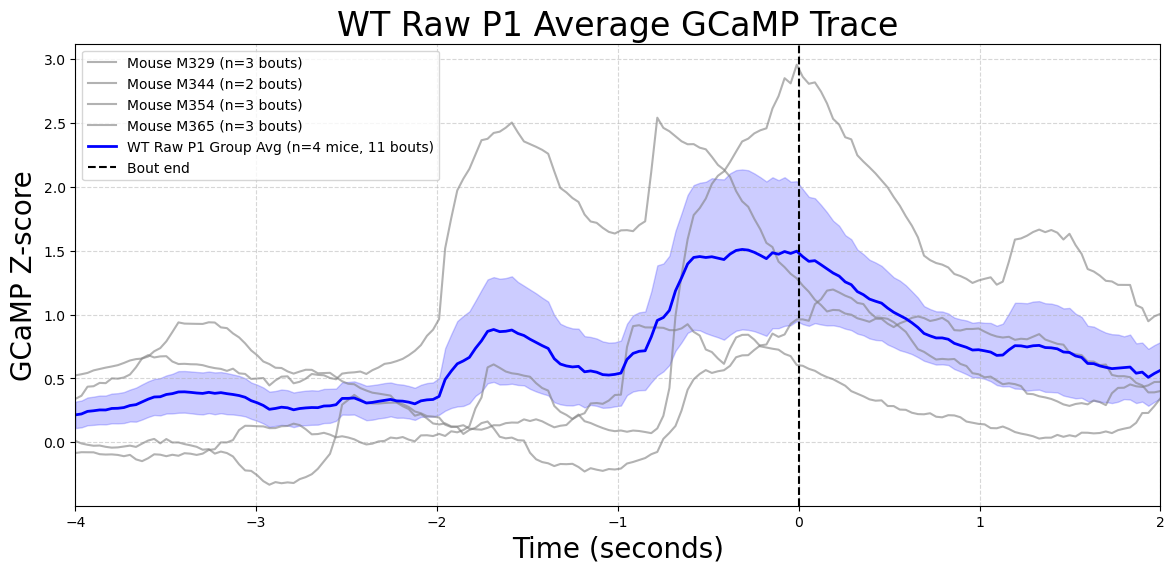

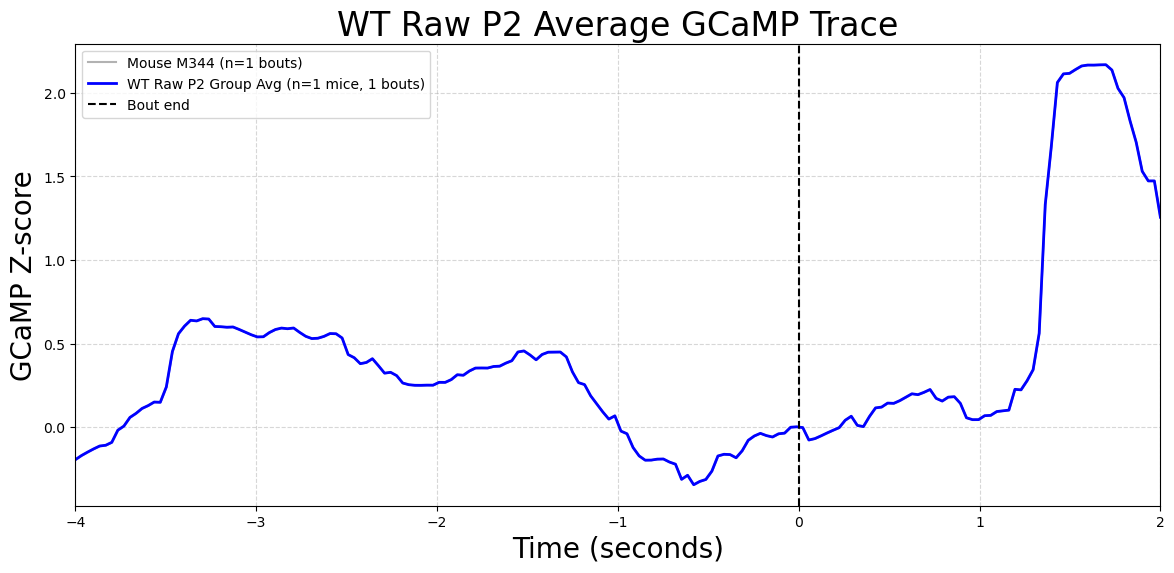

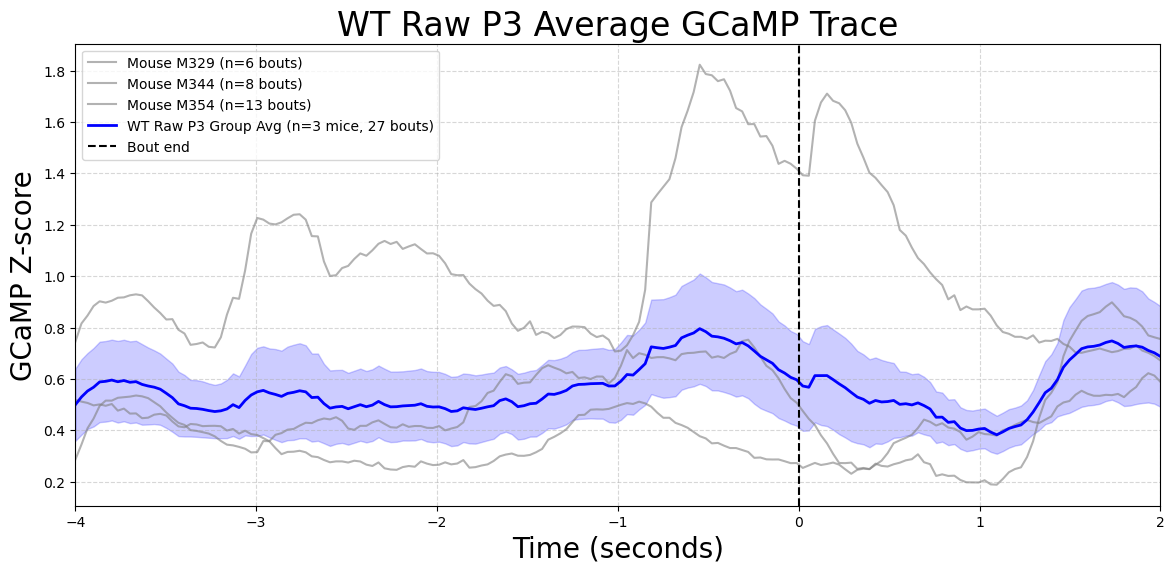

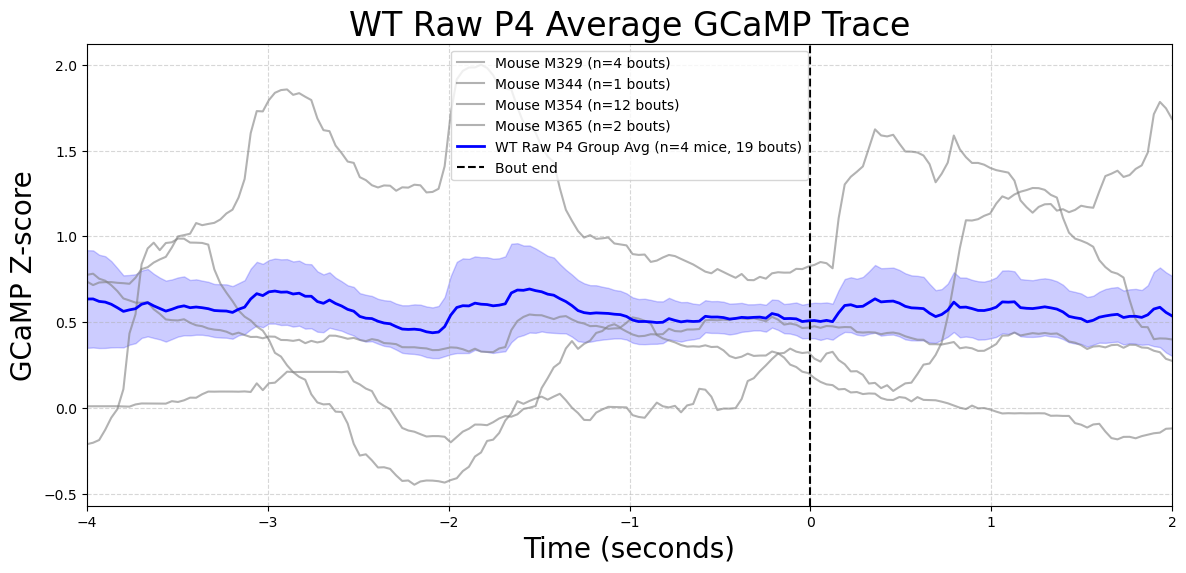

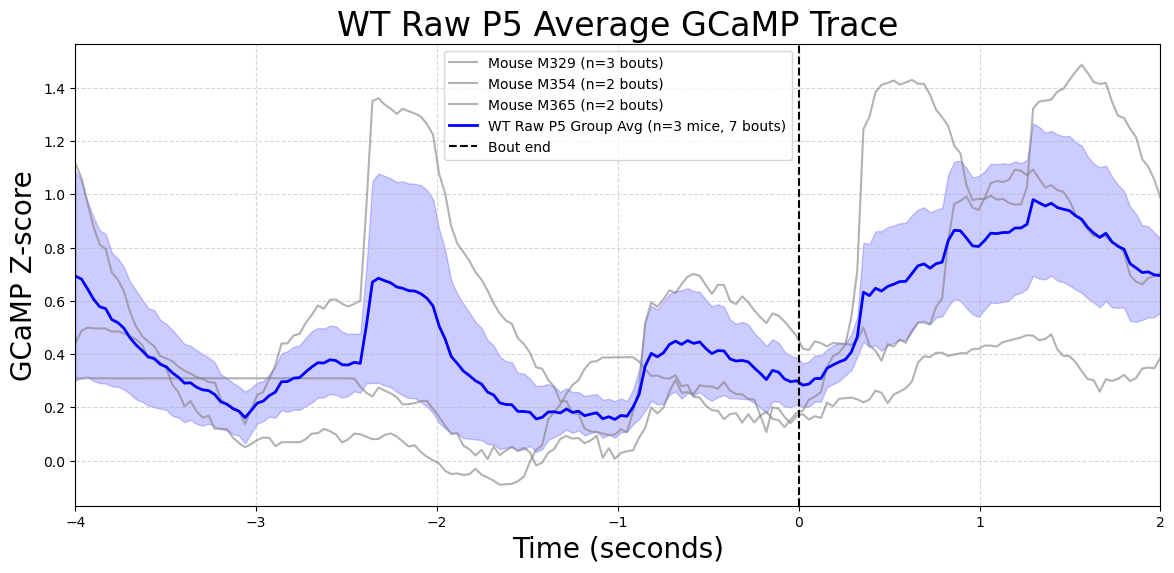

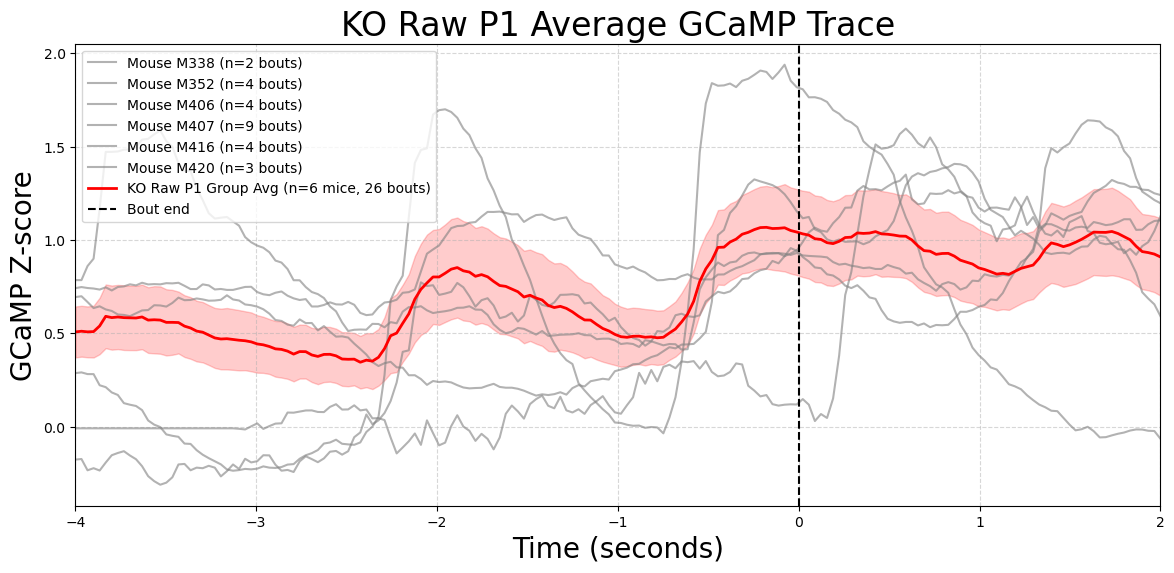

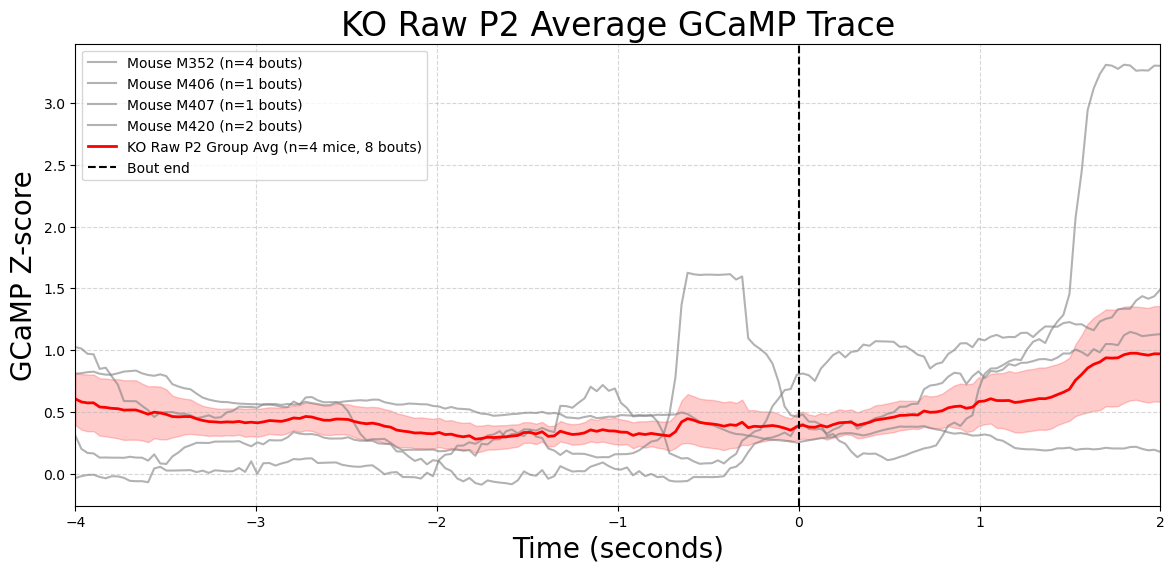

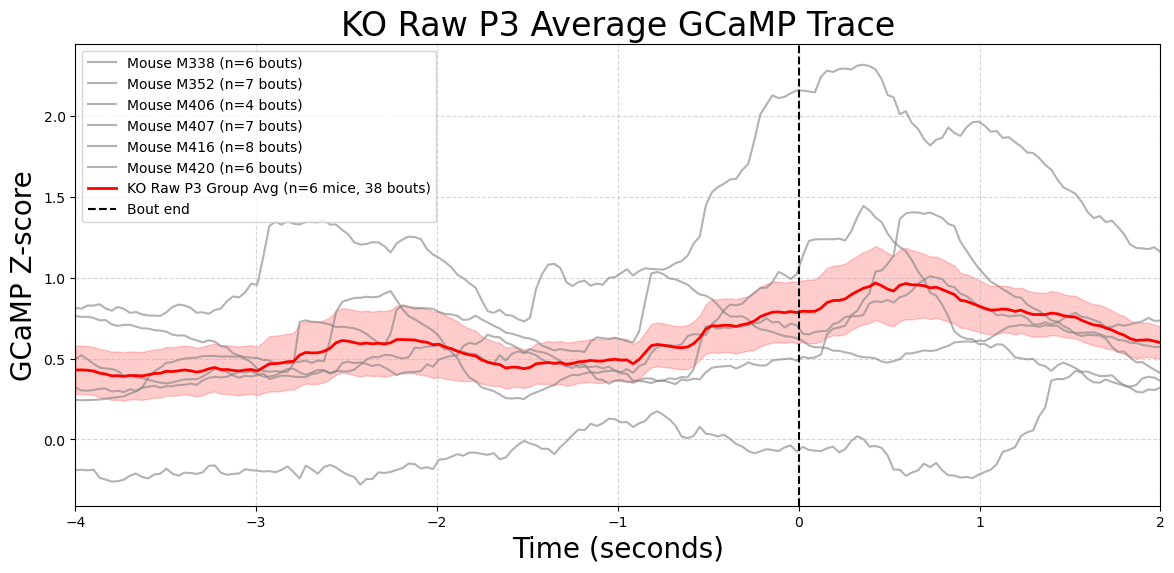

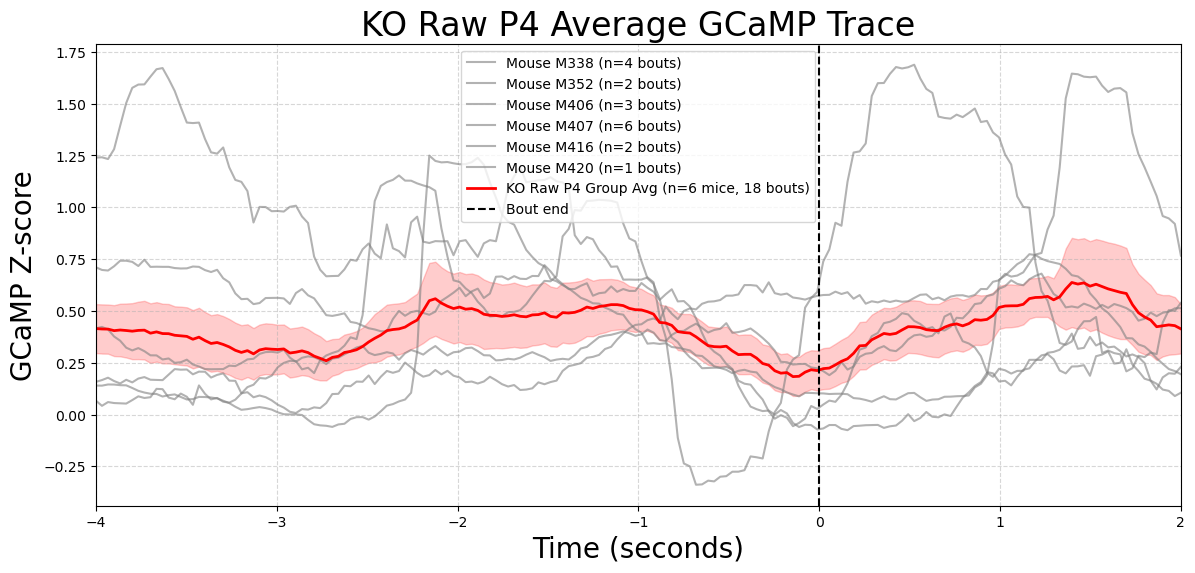

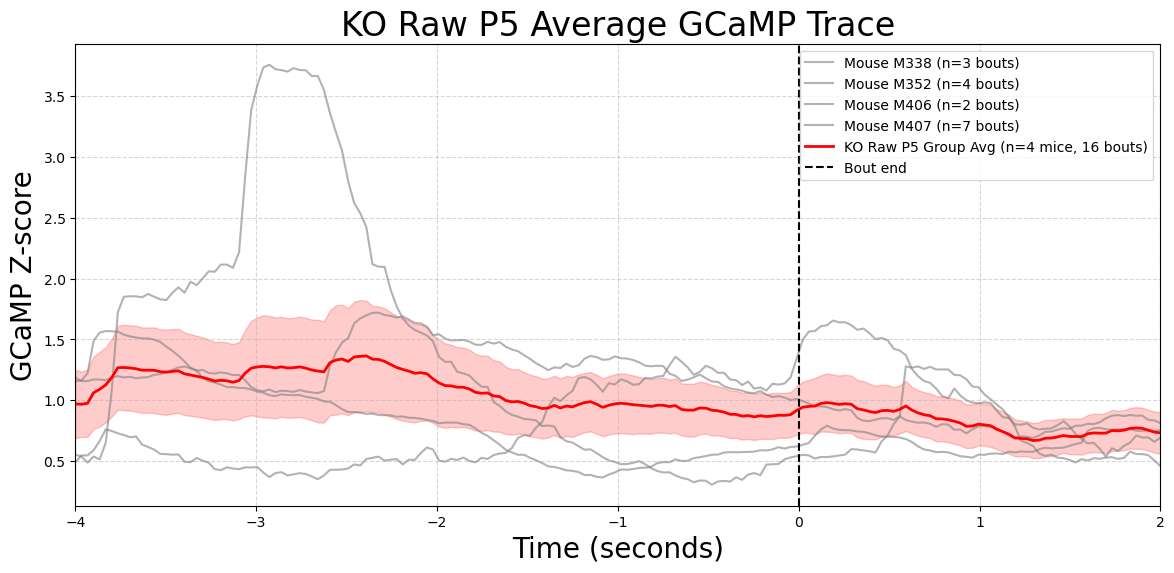

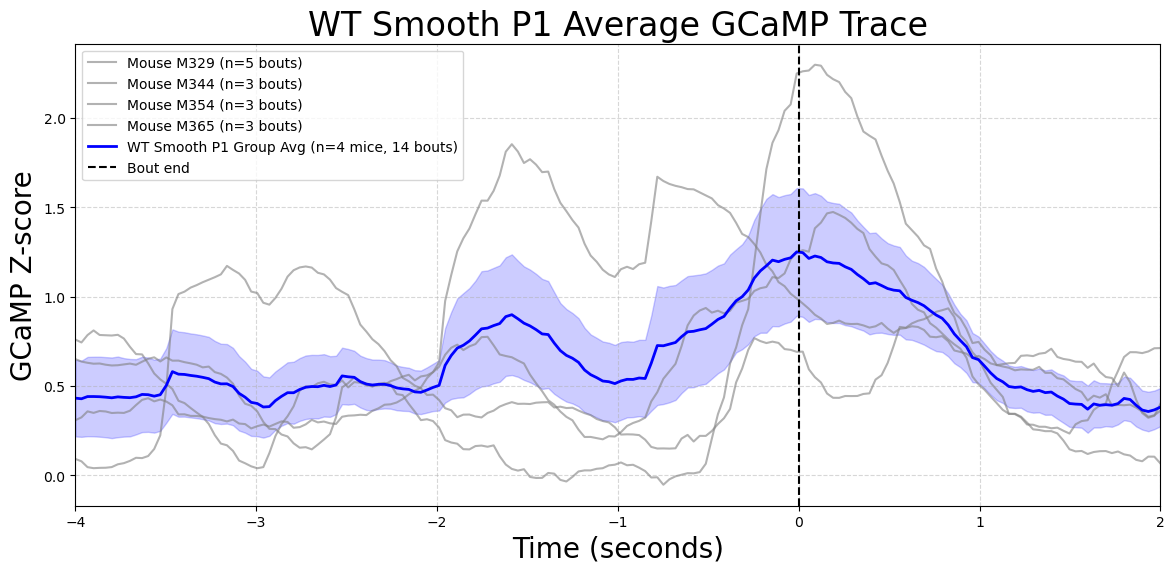

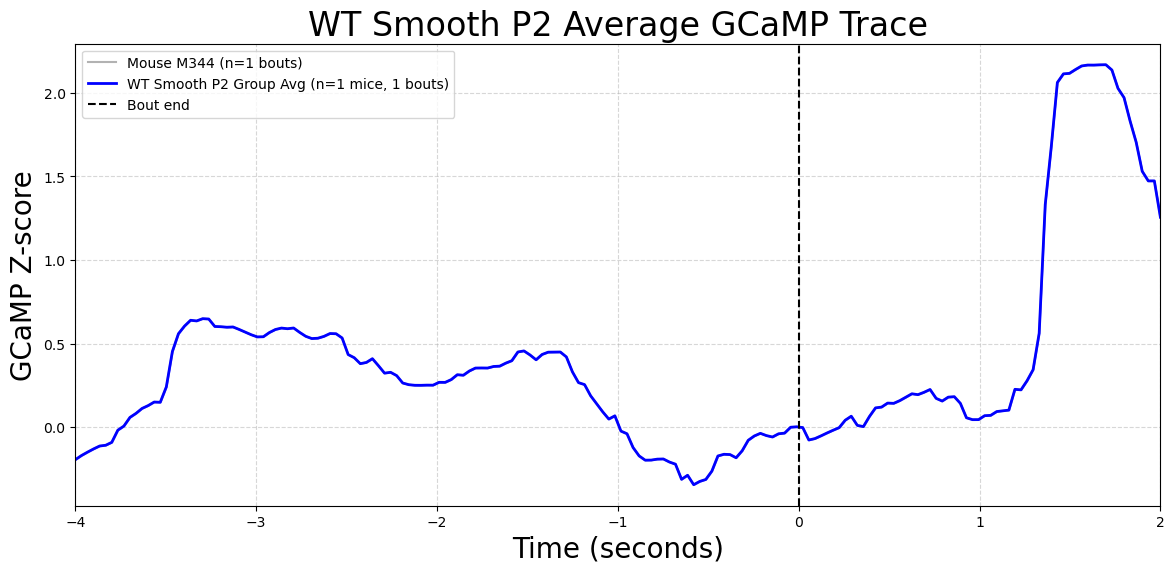

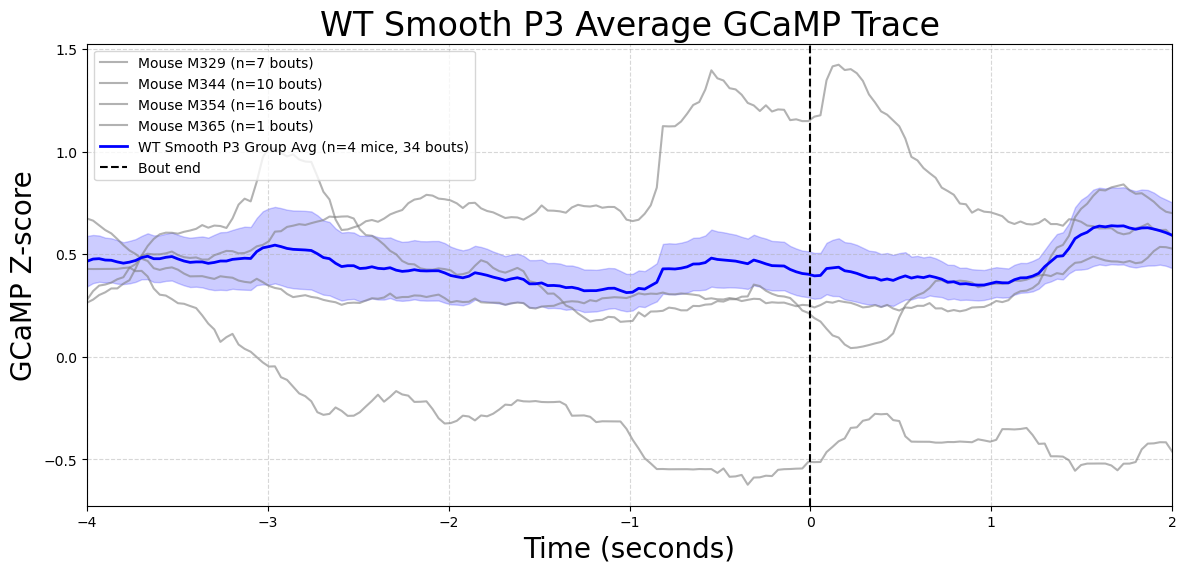

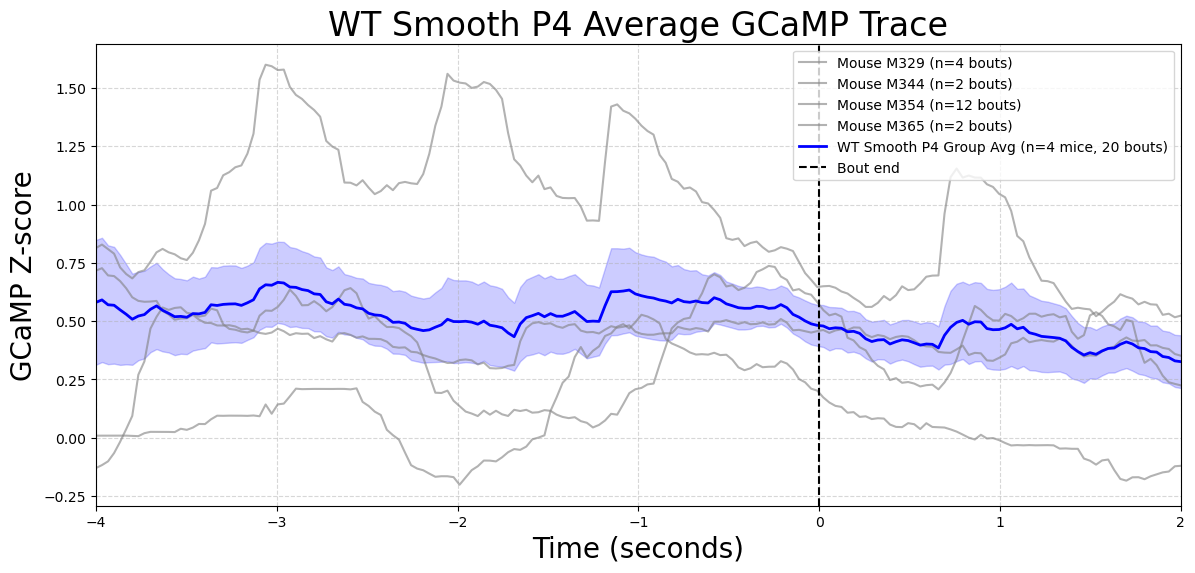

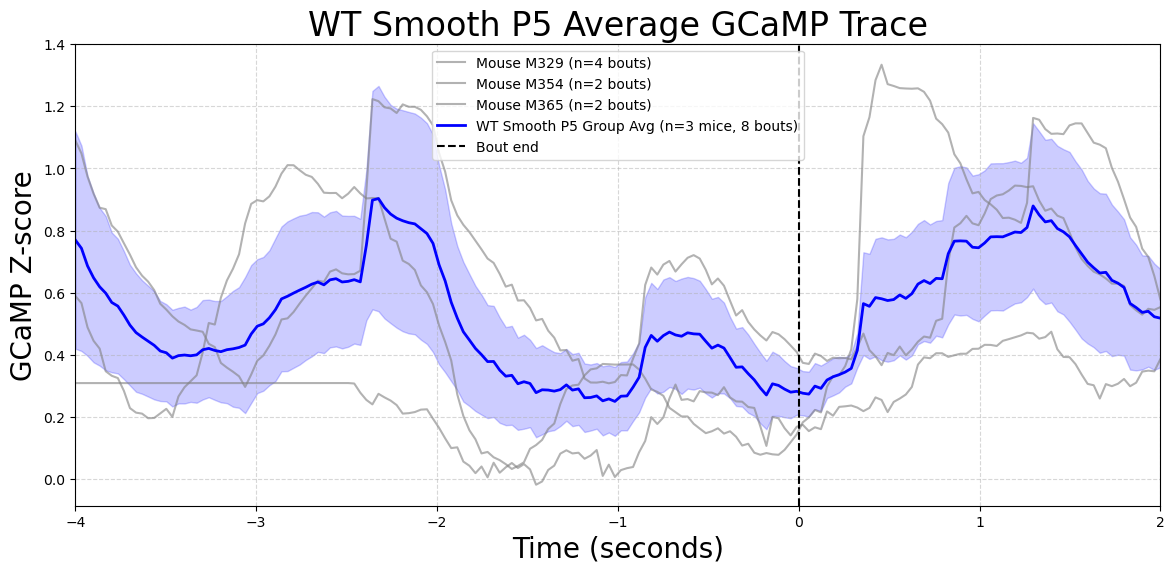

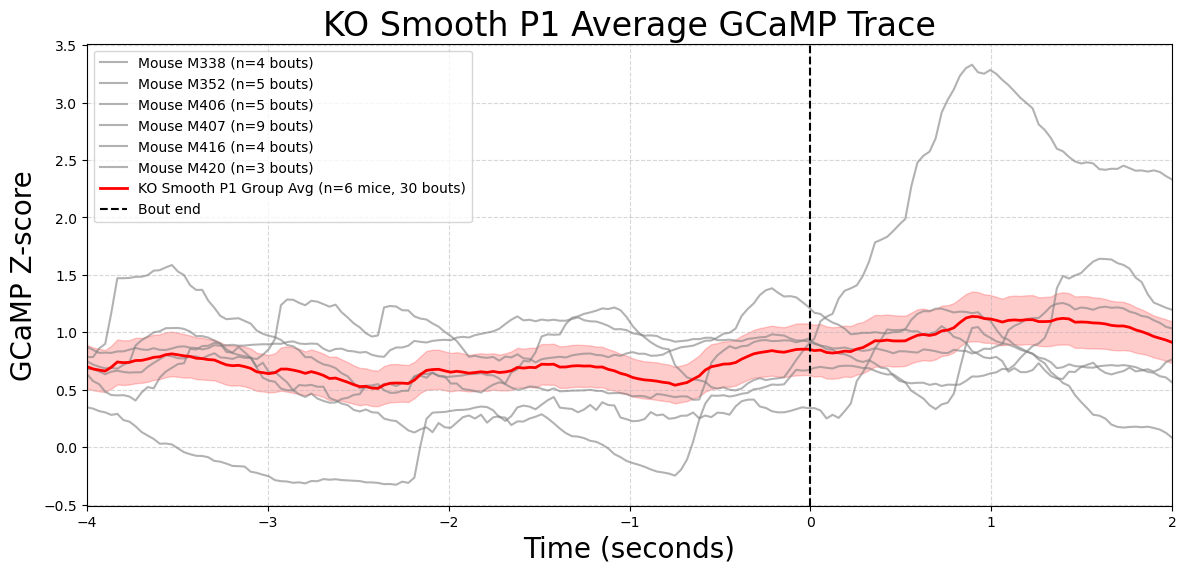

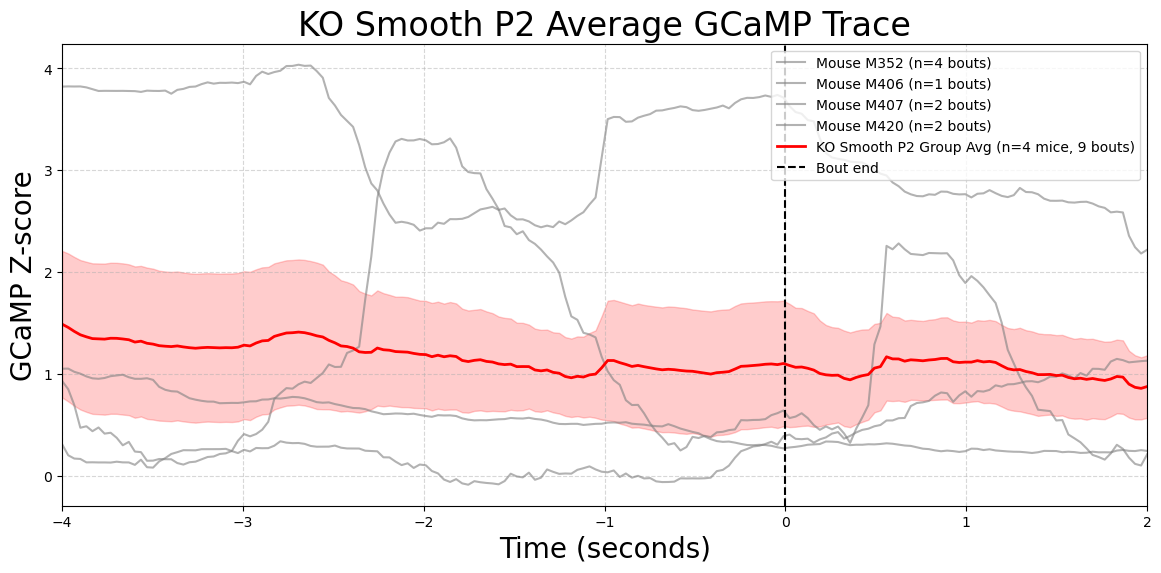

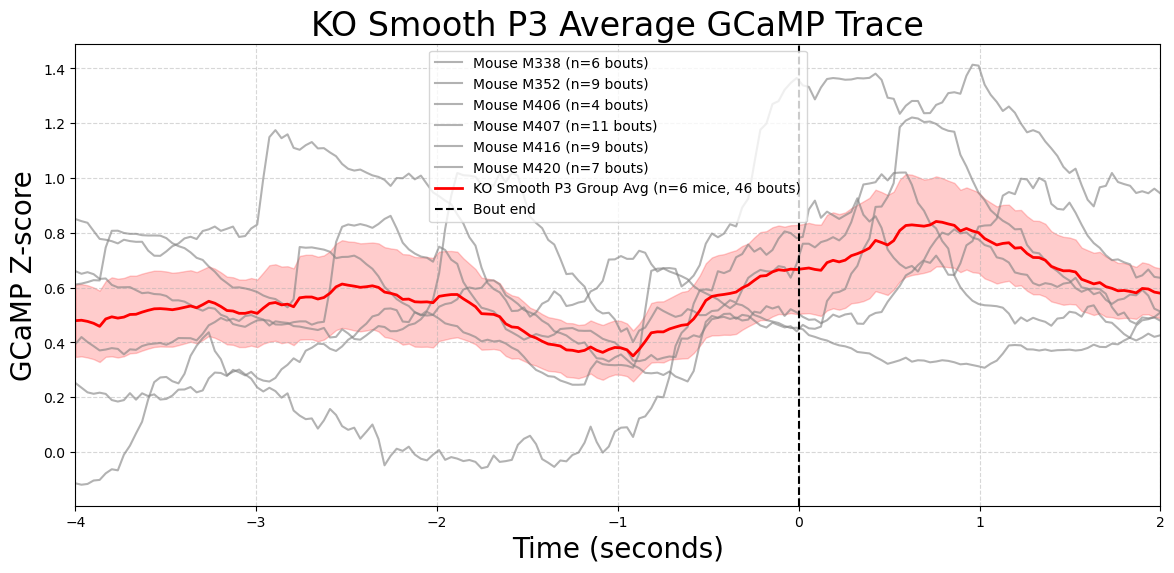

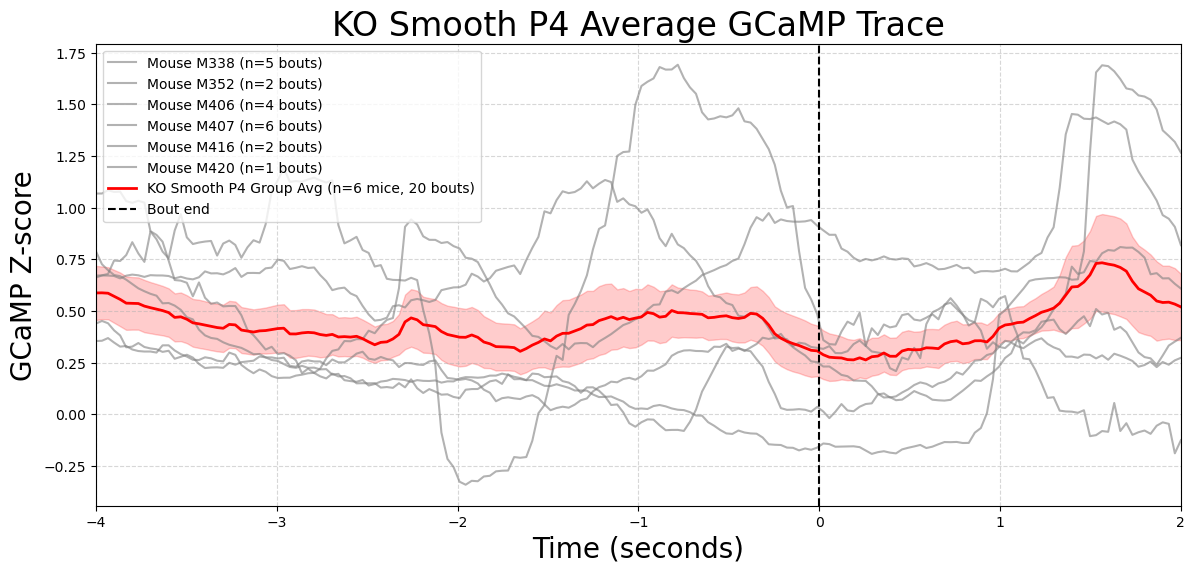

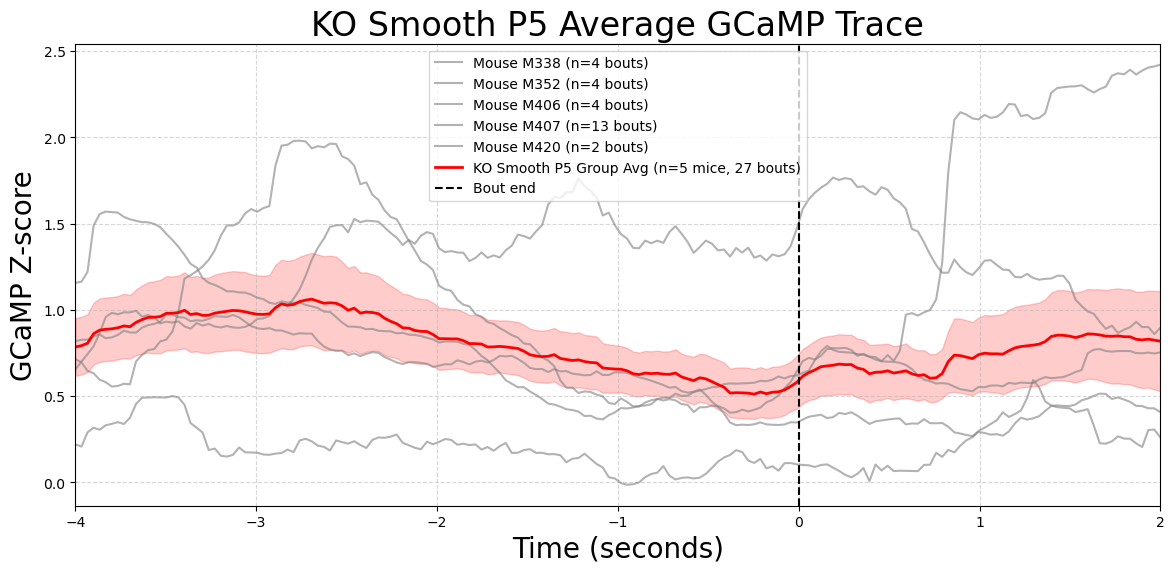

In [11]:
def plot_group_traces_by_bin(avg_time, mouse_avg, group_avg, aligned_by_bin, group_name, color):
    """
    Plot per-mouse and group-averaged GCaMP Z-score traces for each time bin.
    """
    for bn, mouse_traces in mouse_avg.items():
        grp_info = group_avg.get(bn, {})
        avg_trace = grp_info.get('avg')
        sem_trace = grp_info.get('sem')
        if avg_trace is None:
            print(f"Skipping plot for {group_name} in {bn} (No valid data)")
            continue
        plt.figure(figsize=(14, 6))
        # plot each mouse
        for mid, tdat in mouse_traces.items():
            n_bouts_mouse = len(aligned_by_bin.get(bn, {}).get(mid, []))
            plt.plot(avg_time, tdat['avg'], color='gray', alpha=0.6, linewidth=1.5,
                     label=f'Mouse {mid} (n={n_bouts_mouse} bouts)')
        # group avg and SEM
        n_mice = len(mouse_traces)
        n_bouts = sum(len(aligned_by_bin.get(bn, {}).get(mid, [])) for mid in mouse_traces)
        plt.plot(avg_time, avg_trace, color=color, linewidth=2,
                 label=f'{group_name} {bn} Group Avg (n={n_mice} mice, {n_bouts} bouts)')
        plt.fill_between(avg_time, avg_trace - sem_trace, avg_trace + sem_trace, color=color, alpha=0.2)
        plt.axvline(0, color='k', linestyle='--', label='Bout end')
        plt.xlabel('Time (seconds)', fontsize=20)
        plt.ylabel('GCaMP Z-score', fontsize=20)
        plt.title(f'{group_name} {bn} Average GCaMP Trace', fontsize=24)
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.xlim(-pre_bout_seconds, bout_seconds)
        plt.show()

# Plot raw
plot_group_traces_by_bin(avg_time, wt_mouse_avg_raw, wt_group_avg_raw, wt_aligned_raw, 'WT Raw', color='blue')
plot_group_traces_by_bin(avg_time, ko_mouse_avg_raw, ko_group_avg_raw, ko_aligned_raw, 'KO Raw', color='red')
# Plot smoothed
plot_group_traces_by_bin(avg_time, wt_mouse_avg_smooth, wt_group_avg_smooth, wt_aligned_smooth, 'WT Smooth', color='blue')
plot_group_traces_by_bin(avg_time, ko_mouse_avg_smooth, ko_group_avg_smooth, ko_aligned_smooth, 'KO Smooth', color='red')